# DL Lab 1.2 - Homework - Implementing a Multi-layer Perceptron in NumPy

In this homework you will implement a Multi-layer Perceptron, i.e., a two layer neural network, using NumPy.

***

**After completing this homework you will**

- Be able to implement **dense** and **sigmoid activation** layers
- Be able to design **Neural Network architectures** containing dense layers and sigmoid activation
- Be able to **forward** images through your Neural Network
- Be able to compute the **binary cross-entropy loss** for measuring the Network's prediction error
- Be able to perform **backpropagation** using the chain rule

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines marked by "<font color='green'>`# TODO`</font>" denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=146885) in Moodle.

Let's get started!

***

<font color='darkblue'>
  
**Remember**  
- Run your cells using SHIFT+ENTER (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
</font>

## 0 - Packages
At first, let's import the packages we will need today:

- [numpy](www.numpy.org) remember our first lab: NumPy is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sys

%matplotlib inline

BTW: Line numbers can be enabled by pressing `CTRL`+`M`+`L`.

## 1 - Obtaining the Image Dataset

Execute the code below for downloading the dataset to `/tmp/binary_flowers.npz`:

In [ ]:
#@title Download dataset
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

download_file_from_google_drive('1BoDcLIEqfb9qD5VJBKr4BhArluPyOBrh', '/tmp/binary_flowers.npz')

The dataset is provided as archive of numpy arrays, each stored as binary file. We'll unpack them to `X_train, Y_train, X_validation, Y_validation`:

In [ ]:
with np.load('/tmp/binary_flowers.npz') as data:
    X_train, Y_train, X_validation, Y_validation = [ data[key] for key in ['X_train', 'y_train', 'X_test', 'y_test'] ]
    # cast to signed dtype
    Y_train = Y_train.astype(int)
    Y_validation = Y_validation.astype(int)

Let's plot some images to get an idea about the task:

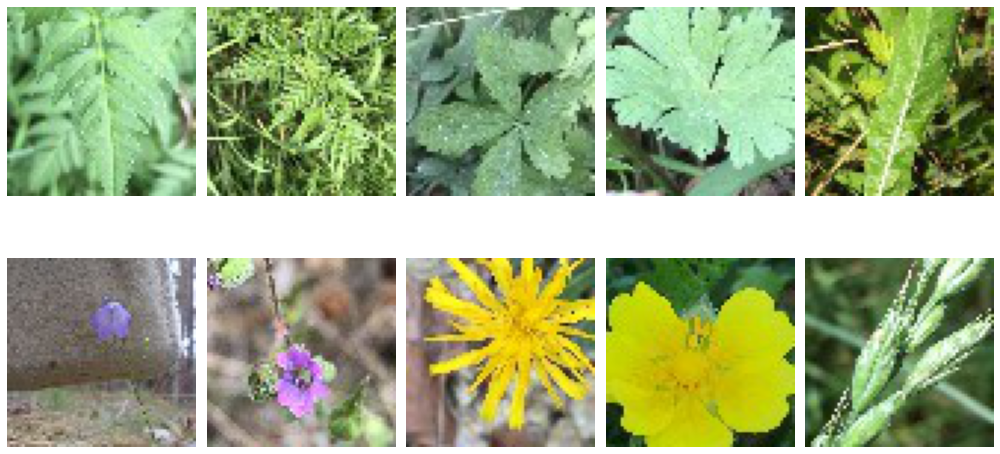

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
fig.set_size_inches(14, 8)
ax = ax.flatten()
for class_ in range(2):
  for sample_ in range(5):
    img = X_train[Y_train == class_][sample_] + .5
    ax[5*class_ + sample_].axis('Off')
    ax[5*class_ + sample_].imshow(img)
plt.tight_layout()
plt.show()

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X_train` and `Y_train`? 

In [ ]:
# TODO (≈ 3 LOC)
print(np.shape(X_train))
print(np.shape(Y_train))
print('Number of training examples:', np.shape(X_train)[0])

(1800, 64, 64, 3)
(1800,)
Number of training examples: 1800


### Vectorization over Training Examples

In order to vectorize our code, we have to reshape our images of shape `(n_samples, width, height, channels)` in an array of shape `(n_features, n_samples)`

**Exercise**: Reshape the training and test data. Evaluate your result by plotting the first training sample. For plotting as image, you'll again have to reshape to an array of shape `(width, height, channels)`. **Make sure the plotted image displays a flower.**

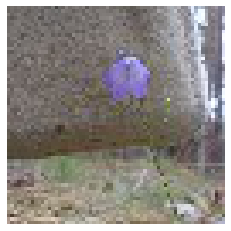

In [ ]:
# reshape `X_train` to (n_features, n_samples)
X_train = X_train.reshape(1800,X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_train = X_train.T
assert X_train.shape == (12288, 1800), 'Wrong shape for `X_train`: {}'.format(X_train.shape)


# reshape `X_validation` to (n_features, n_samples)
X_validation = X_validation.reshape(200,X_validation.shape[1]*X_validation.shape[2]*X_validation.shape[3])
X_validation = X_validation.T
assert X_validation.shape == (12288, 200), 'Wrong shape for `X_validation`: {}'.format(X_validation.shape)

plt.imshow(X_train[:, 0].reshape(64,64,3) + .5)
plt.axis('off')
plt.show()

## 2 - Implement Layers and Loss function

Our network will contain dense layers and sigmoid activation layers. We objectify these layers for making the forward and backward computations easier. In detail, each layer class will have a `forward` and `backward` method that are callable on arbitrary inputs of defined shape.

**Exercise**: The code below contains several <font color='green'>`# TODO`</font>s. Your task is to complete the code.

In [ ]:
class Dense:
  ''' Dense layer with weight matrix `W` and bias vector `b`
  
  Arguments:
  ---
    neurons : number of neurons in layer; equal to output dimension of layer
    input_shape : shape of input data (num_features, num_samples)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
    update( learning_rate )
  '''

  def __init__(self, neurons, input_shape):

    self.input_shape = input_shape
    self.neurons = neurons

    # initialize with normal distributed random weights
    self.W = np.random.normal( scale=.1, size=(self.neurons, self.input_shape[0]))
    self.b = np.random.normal( scale=.1, size=(self.neurons, 1))

    # allocate output (neurons, m)
    self.Z_out = np.zeros( (self.neurons, self.input_shape[1]))


  def forward(self, A_in):
    ''' Forward pass of `A_in` through dense layer. Output is stored in `Z_out`. '''
    
    # store layer input
    self.A_in = A_in  
    # compute layer output
    self.Z_out = np.dot(self.W, self.A_in) + self.b # dot of w matrix and input features + bias matrix


  def backward(self, gradient):
    ''' Backward pass of `gradient` through dense layer. Outputs are stored in `dW`, `db`, `dA_in`. '''

    # derivative w.r.t. W
    self.dW = np.dot(gradient,self.A_in.T)

    # derivative w.r.t. b
    self.db = np.sum(gradient, axis=1, keepdims=True)

    # derivative w.r.t. A_in
    self.dA_in = np.dot(self.W.T, gradient)


  def update(self):
    print('update')
    ''' Update layer parameters `W`, `b` using global `LEARNING_RATE` '''
    
    # update weights and bias
    self.W = self.W - LEARNING_RATE * self.dW
    self.b = self.b - LEARNING_RATE * self.db 

In [ ]:
class Sigmoid:
  ''' Activation layer using the logistic function (aka sigmoid function)
  
  Arguments:
  ---
    input_shape : shape of input data (num_features, num_samples)
  
  Methods:
  ---
    forward( input )
    backward( gradient )
  '''

  def __init__(self, input_shape):
    # allocate output
    self.A_out = np.zeros( input_shape )

  def forward(self, Z_in):
    ''' Forward pass of `Z_in`: compute sigmoid activation. Output is stored in `A_out`. '''
    self.A_out = 1/(1+np.exp(-Z_in))

  def backward(self, gradient):
    ''' Backward pass of `gradient` through sigmoid layer. Output is stored in `dZ`. '''
    self.dZ = gradient * self.A_out*(1 - self.A_out) #ds=s*(1-s)  

In [ ]:
def binary_cross_entropy_loss(Y, Y_hat):
  print('binary_cross_entropy_loss')
  ''' Return average binary cross-entropy loss across predictions `Y_hat` and its gradient w.r.t. `Y_hat`

  Arguments:
  ---
    Y : Ground truth data labels (expected labels)
    Y_hat : Predicted labels (output of last layer)

  Returns:
  ---
    loss : value of the binary cross-entropy loss
    dY_hat : gradient of loss w.r.t. Y_hat
  '''

  loss = np.sum(-Y * np.log(Y_hat) - (1 - Y) * np.log(1 - Y_hat))
  dY_hat = (Y_hat - Y) / (Y_hat*(1 - Y_hat)) #dl/dyhat A2=Y_har

  return loss, dY_hat

## 3 - Implementing a 2 Layer Neural Network

Using the layers and the loss function defined above, we can now implement our neural network.

In [ ]:
class NeuralNet:
  ''' Feed-forward neural network with two layers

  Arguments:
  ---
  input_shape : shape of input data
  batch_size : batch size (default=100)
  shuffle : shuffle data during training (default=True)
  
  Methods:
  ---
  fit
  predict
  '''

  def __init__(self, input_shape, batch_size=100, shuffle=True, seed=42):
    self.input_shape = input_shape
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.random = np.random.RandomState(seed)
    self.set_architecture()
    print('Initialized Neural Network with {} parameters.'.format(self.number_of_parameters))

  def set_architecture(self):
    # hidden layer with 10 neurons
    self.Z1 = Dense(10,
                    (self.input_shape[0], self.batch_size))
    # sigmoid activation of hidden layer output
    self.A1 = Sigmoid(self.Z1.Z_out.shape)
    
    # output layer with 1 neuron (binary classification)
    self.Z2 = Dense(1,
                    self.A1.A_out.shape)
    # sigmoid activation of output layer output
    self.A2 = Sigmoid(self.Z2.Z_out.shape)

  @property
  def number_of_parameters(self):
    self._number_of_parameters = np.sum(
        [param.size for param in ( self.Z1.W, self.Z1.b, self.Z2.W, self.Z2.b )]
          )
    return self._number_of_parameters

  def _forward(self, X):
    ''' Propagate input `X` through network. '''
    self.Z1.forward(X)
    self.A1.forward(self.Z1.Z_out)
    self.Z2.forward(self.A1.A_out)
    self.A2.forward(self.Z2.Z_out)

  def _backprop(self, dY_hat):
    ''' backpropagate gradient `dY_hat` w.r.t. predicted output through the network. '''
    self.A2.backward(dY_hat)
    self.Z2.backward(self.A2.dZ)
    self.A1.backward(self.Z2.dA_in)
    self.Z1.backward(self.A1.dZ)

  def _update(self):
    self.Z2.update()
    self.Z1.update()

  def predict(self, X):
    ''' Predict binary labels of X
    
    Arguments:
    ---
    X : Array of input features; shape = (n_features, m)
    '''
    self._forward(X)
    return np.round( self.A2.A_out )

  def fit(self, X_train, Y_train, X_validation, Y_validation, epochs):
    ''' Train on training data, validate on validation data

    Arguments:
    ---
    X_train : input training data
    Y_train : labels of training data
    X_validation : input validation data
    Y_validation : labels of validation data
    epochs : number of epochs to train
    '''

    train_steps = X_train.shape[1] / self.batch_size

    epoch_strlen = len(str(epochs))

    history = {'loss':list(), 'train_acc':list(), 'val_acc':list()}
    epoch_stats = {'loss':0, 'train_acc':0, 'val_acc':0}

    # iterate over training epochs
    for i in range(epochs):

      # iterate over minibatches
      indices = np.arange( X_train.shape[1] )

      if self.shuffle:
        self.random.shuffle(indices)

      for start_idx in range(0, indices.shape[0] - self.batch_size + 1, self.batch_size):
        batch_indices = indices[start_idx:start_idx + self.batch_size]
        
        # forward propagate batch of samples
        self._forward(X_train[:, batch_indices])
        epoch_stats['train_acc'] += np.sum( np.round(self.A2.A_out) == Y_train[batch_indices])

        # compute loss and gradient
        loss, dAout = binary_cross_entropy_loss(Y_train[batch_indices], self.A2.A_out)
        epoch_stats['loss'] += loss

        # backpropagate gradient
        self._backprop(dAout)

        # update weights
        self._update()
      
      epoch_stats['loss'] /= train_steps
      epoch_stats['train_acc'] /= (train_steps * self.batch_size)
      
      # eval on validation split after each epoch
      Y_validation_hat = self.predict(X_validation)
      epoch_stats['val_acc'] = np.mean(Y_validation_hat == Y_validation)

      sys.stderr.write('\rProgress: {}/{} | '.format(i+1, epochs) + \
                       'Loss: {:.2f} | '.format(epoch_stats['loss']) + \
                       'train accuracy: {:.2f}% | '.format(epoch_stats['train_acc']*100) + \
                       'validation accuracy: {:.2f}% '.format(epoch_stats['val_acc']*100)
                       )
      
      sys.stderr.flush()

      # store history
      history['loss'].append(epoch_stats['loss'])
      history['train_acc'].append(epoch_stats['train_acc'])
      history['val_acc'].append(epoch_stats['val_acc'])

    return history

## 4 - Testing the Forward Computation

Now it's time to initialize the network and test the forward propagation.

Let's define some hyperparameters and create an instance of our `NeuralNet`:

In [ ]:
# Hyperparameters
BATCHSIZE = 50
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100

In [ ]:
my_NN = NeuralNet(X_train.shape, batch_size=BATCHSIZE)

Initialized Neural Network with 122901 parameters.


The layers were initialized with random weights. Hence, the untrained network will return random predictions.
The validation split is balanced, i.e., it contains the same amount of positive and negative samples. For binary classification on balanced data, random guessing should return an accuracy of roughly 50%:

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 48.5%


## 5 - Training and Evaluation

Now it's time to finally train your network. 

Train it for 100 epochs with a minibatch size of 100 using the `.fit()` method:

In [ ]:
history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 1/100 | Loss: 34.82 | train accuracy: 48.72% | validation accuracy: 54.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 2/100 | Loss: 35.46 | train accuracy: 54.30% | validation accuracy: 58.50% 


update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss

Progress: 3/100 | Loss: 35.15 | train accuracy: 59.25% | validation accuracy: 61.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 4/100 | Loss: 34.66 | train accuracy: 62.03% | validation accuracy: 65.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 5/100 | Loss: 33.91 | train accuracy: 67.03% | validation accuracy: 69.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 6/100 | Loss: 32.88 | train accuracy: 69.59% | validation accuracy: 73.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 7/100 | Loss: 31.59 | train accuracy: 71.65% | validation accuracy: 76.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 8/100 | Loss: 30.21 | train accuracy: 73.65% | validation accuracy: 77.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 9/100 | Loss: 28.92 | train accuracy: 75.49% | validation accuracy: 77.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 10/100 | Loss: 27.77 | train accuracy: 76.04% | validation accuracy: 78.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 11/100 | Loss: 26.79 | train accuracy: 76.82% | validation accuracy: 79.50% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 12/100 | Loss: 25.97 | train accuracy: 77.04% | validation accuracy: 78.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 13/100 | Loss: 25.22 | train accuracy: 77.99% | validation accuracy: 79.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 14/100 | Loss: 24.57 | train accuracy: 78.93% | validation accuracy: 80.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 15/100 | Loss: 23.94 | train accuracy: 79.49% | validation accuracy: 80.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 16/100 | Loss: 23.37 | train accuracy: 80.16% | validation accuracy: 80.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 17/100 | Loss: 22.82 | train accuracy: 80.93% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 18/100 | Loss: 22.24 | train accuracy: 81.16% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 19/100 | Loss: 21.72 | train accuracy: 82.05% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 20/100 | Loss: 21.23 | train accuracy: 82.21% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 21/100 | Loss: 20.71 | train accuracy: 83.43% | validation accuracy: 83.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 22/100 | Loss: 20.21 | train accuracy: 83.82% | validation accuracy: 82.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 23/100 | Loss: 19.68 | train accuracy: 84.71% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 24/100 | Loss: 19.22 | train accuracy: 85.66% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 25/100 | Loss: 18.78 | train accuracy: 86.16% | validation accuracy: 83.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 26/100 | Loss: 18.34 | train accuracy: 86.94% | validation accuracy: 84.00% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 27/100 | Loss: 17.90 | train accuracy: 86.83% | validation accuracy: 84.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 28/100 | Loss: 17.47 | train accuracy: 87.60% | validation accuracy: 85.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 29/100 | Loss: 17.06 | train accuracy: 88.05% | validation accuracy: 84.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 30/100 | Loss: 16.66 | train accuracy: 88.55% | validation accuracy: 84.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 31/100 | Loss: 16.31 | train accuracy: 89.16% | validation accuracy: 85.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 32/100 | Loss: 15.95 | train accuracy: 89.27% | validation accuracy: 84.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 33/100 | Loss: 15.59 | train accuracy: 89.83% | validation accuracy: 85.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 34/100 | Loss: 15.26 | train accuracy: 90.16% | validation accuracy: 84.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 35/100 | Loss: 14.89 | train accuracy: 90.44% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 36/100 | Loss: 14.58 | train accuracy: 90.77% | validation accuracy: 83.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 37/100 | Loss: 14.26 | train accuracy: 90.61% | validation accuracy: 83.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 38/100 | Loss: 13.91 | train accuracy: 91.38% | validation accuracy: 83.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 39/100 | Loss: 13.66 | train accuracy: 90.88% | validation accuracy: 83.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 40/100 | Loss: 13.36 | train accuracy: 91.44% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 41/100 | Loss: 13.04 | train accuracy: 91.72% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 42/100 | Loss: 12.77 | train accuracy: 91.83% | validation accuracy: 84.00% 


binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update

Progress: 43/100 | Loss: 12.56 | train accuracy: 92.16% | validation accuracy: 83.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 44/100 | Loss: 12.26 | train accuracy: 92.66% | validation accuracy: 84.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 45/100 | Loss: 12.02 | train accuracy: 92.55% | validation accuracy: 83.00% 


binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update

Progress: 46/100 | Loss: 11.74 | train accuracy: 92.77% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 47/100 | Loss: 11.49 | train accuracy: 93.22% | validation accuracy: 83.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 48/100 | Loss: 11.27 | train accuracy: 93.44% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 49/100 | Loss: 11.00 | train accuracy: 93.83% | validation accuracy: 83.00% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 50/100 | Loss: 10.78 | train accuracy: 93.61% | validation accuracy: 82.50% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 51/100 | Loss: 10.54 | train accuracy: 94.22% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 52/100 | Loss: 10.32 | train accuracy: 94.44% | validation accuracy: 83.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 53/100 | Loss: 10.08 | train accuracy: 94.50% | validation accuracy: 83.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 54/100 | Loss: 9.86 | train accuracy: 94.83% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 55/100 | Loss: 9.67 | train accuracy: 95.33% | validation accuracy: 82.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 56/100 | Loss: 9.45 | train accuracy: 95.22% | validation accuracy: 83.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 57/100 | Loss: 9.28 | train accuracy: 95.16% | validation accuracy: 82.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 58/100 | Loss: 9.10 | train accuracy: 95.55% | validation accuracy: 82.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 59/100 | Loss: 8.89 | train accuracy: 95.94% | validation accuracy: 83.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 60/100 | Loss: 8.69 | train accuracy: 95.72% | validation accuracy: 82.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 61/100 | Loss: 8.51 | train accuracy: 96.11% | validation accuracy: 83.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 62/100 | Loss: 8.33 | train accuracy: 96.16% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 63/100 | Loss: 8.16 | train accuracy: 96.11% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 64/100 | Loss: 8.02 | train accuracy: 96.39% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 65/100 | Loss: 7.82 | train accuracy: 96.55% | validation accuracy: 81.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 66/100 | Loss: 7.68 | train accuracy: 96.61% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 67/100 | Loss: 7.51 | train accuracy: 96.66% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 68/100 | Loss: 7.35 | train accuracy: 96.72% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 69/100 | Loss: 7.21 | train accuracy: 96.55% | validation accuracy: 81.00% 


binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update

Progress: 70/100 | Loss: 7.05 | train accuracy: 97.05% | validation accuracy: 82.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 71/100 | Loss: 6.89 | train accuracy: 97.11% | validation accuracy: 82.00% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 72/100 | Loss: 6.79 | train accuracy: 97.11% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 73/100 | Loss: 6.65 | train accuracy: 97.28% | validation accuracy: 83.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 74/100 | Loss: 6.52 | train accuracy: 97.50% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 75/100 | Loss: 6.36 | train accuracy: 97.39% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 76/100 | Loss: 6.28 | train accuracy: 97.39% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 77/100 | Loss: 6.14 | train accuracy: 97.33% | validation accuracy: 81.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 78/100 | Loss: 6.02 | train accuracy: 97.67% | validation accuracy: 81.50% 


update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss

Progress: 79/100 | Loss: 5.91 | train accuracy: 97.67% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 80/100 | Loss: 5.78 | train accuracy: 97.78% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 81/100 | Loss: 5.67 | train accuracy: 97.94% | validation accuracy: 81.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 82/100 | Loss: 5.54 | train accuracy: 97.94% | validation accuracy: 82.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 83/100 | Loss: 5.50 | train accuracy: 98.11% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 84/100 | Loss: 5.35 | train accuracy: 98.17% | validation accuracy: 82.50% 

update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update


Progress: 85/100 | Loss: 5.26 | train accuracy: 98.17% | validation accuracy: 80.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 86/100 | Loss: 5.15 | train accuracy: 98.22% | validation accuracy: 81.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 87/100 | Loss: 5.06 | train accuracy: 98.39% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 88/100 | Loss: 4.96 | train accuracy: 98.28% | validation accuracy: 81.00% 


update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss

Progress: 89/100 | Loss: 4.88 | train accuracy: 98.33% | validation accuracy: 80.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 90/100 | Loss: 4.78 | train accuracy: 98.33% | validation accuracy: 82.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 91/100 | Loss: 4.69 | train accuracy: 98.39% | validation accuracy: 82.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 92/100 | Loss: 4.62 | train accuracy: 98.44% | validation accuracy: 80.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 93/100 | Loss: 4.52 | train accuracy: 98.50% | validation accuracy: 81.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 94/100 | Loss: 4.46 | train accuracy: 98.50% | validation accuracy: 81.00% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 95/100 | Loss: 4.38 | train accuracy: 98.44% | validation accuracy: 82.00% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 96/100 | Loss: 4.29 | train accuracy: 98.61% | validation accuracy: 81.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 97/100 | Loss: 4.21 | train accuracy: 98.55% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


Progress: 98/100 | Loss: 4.16 | train accuracy: 98.67% | validation accuracy: 81.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 99/100 | Loss: 4.06 | train accuracy: 98.55% | validation accuracy: 81.50% 

update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss


Progress: 100/100 | Loss: 3.99 | train accuracy: 98.72% | validation accuracy: 81.50% 

binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update
binary_cross_entropy_loss
update
update


We can again call the `.predict()` method on the validation data again and see how the network improved:

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 81.5%


In addition, we stored the loss as well the training and validation accuracy of the network after each epoch in the `history` dictionary. Let's plot the learning curve, i.e., the loss over epochs, and the accuracies:

In [ ]:
#@title Definition: `plot_history( history )`
def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history['loss'])
  ax1.set_ylabel('Binary CE Loss')
  
  ax2.plot(history['train_acc'], label='training')
  ax2.plot(history['val_acc'], label='validation', linestyle='--')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show()

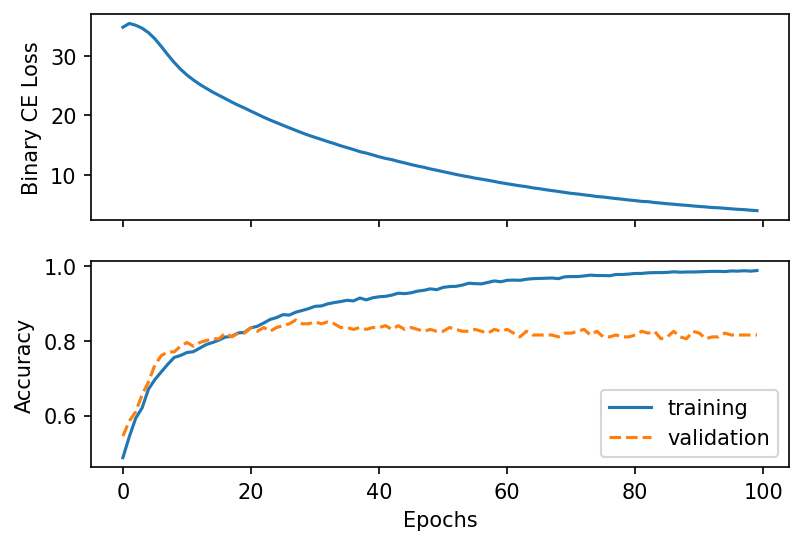

In [ ]:
plot_history(history)

# Congratulations!

You've just coded your own neural network in NumPy and trained it to recognize flowers in images. If everything went smooth, you should achieve a training accuracy of > 95% and validation accuracy > 80%.
You may play a little with the hyperparameters, e.g., change the `LEARNING_RATE` and `BATCHSIZE`. In addition, you may add more parameters to the model by increasing the hidden layer size, i.e., the amount of neurons of the hidden layer.

## Submission Instructions

You may now submit your notebook to moodle:
- Save the notebook (`CTRL`+ `s` or '*File*' -> '*Save*')
- Click on '*File*' -> '*Download .ipynb*' for downloading the notebook as IPython Notebook file.
- Upload the downloaded IPython Notebook file to **Moodle**.